In [1]:
import sys
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json

/home/dtsarev/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
DATASET_PATH = '/home/dtsarev/master_of_cv/sem3/DL_project/data/splits_final_deblurred/'
WEIGHTS = '/home/dtsarev/master_of_cv/sem3/DL_project/weights/deeplab_model_final.pth'
RESULTS = '/home/dtsarev/master_of_cv/sem3/DL_project/data/results/'

In [3]:
JSON_PRED = RESULTS + '/inference/sem_seg_predictions.json'

In [4]:
sys.path.insert(0, os.path.abspath('..'))

In [5]:
from deeplab.train_net import register_zero_waste_semseg, Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer

In [6]:
class Args:
    def __init__(self):
        # Путь к вашему конфигу
        self.config_file = '../deeplab/configs/zerowaste_config.yaml'
        
        # Путь к датасету
        self.dataroot = DATASET_PATH
        
        # Говорим, что хотим только инференс
        self.eval_only = True
        
        # Параметры для запуска в режиме single-GPU
        self.num_gpus = 1
        self.num_machines = 1
        self.machine_rank = 0
        self.dist_url = 'tcp://127.0.0.1:50152'
        
        # Передаём параметры для переопределения в cfg.merge_from_list(...)
        # Обратите внимание, что здесь НЕ используется '--MODEL.WEIGHTS',
        # а просто 'MODEL.WEIGHTS'
        self.opts = [
            'OUTPUT_DIR', RESULTS,
            'MODEL.WEIGHTS', WEIGHTS
        ]
        
        # Нужно ли возобновлять тренировку?
        self.resume = False

In [7]:
# Создаём экземпляр аргументов
args = Args()

# Регистрируем датасет
register_zero_waste_semseg(args.dataroot)

# Загружаем конфигурацию
cfg = setup(args)

# Строим модель
model = Trainer.build_model(cfg)

# Загружаем веса
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    cfg.MODEL.WEIGHTS, resume=args.resume
)

Registering the zero-waste dataset splits
[12/21 17:20:59 detectron2]: Rank of current process: 0. World size: 1
[12/21 17:21:00 detectron2]: Environment info:
-------------------------------  ------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
numpy                            1.24.2
detectron2                       0.6 @/home/dtsarev/anaconda3/lib/python3.11/site-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.3.1+cu121 @/home/dtsarev/anaconda3/lib/python3.11/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            NVIDIA GeForce RTX 4070 (arch=8.9)
Driver version                   550.120
CUD

{'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[ 6.8794e-04,  1.6289e-04, -1.3487e-04],
              [ 1.7113e-04, -3.7236e-04, -6.4356e-04],
              [-8.8088e-05, -5.7806e-04, -7.9896e-04]],
    
             [[ 1.2266e-03,  7.9480e-04,  4.3108e-04],
              [ 1.0298e-03,  6.5608e-04,  2.6725e-04],
              [ 6.4528e-04,  2.7417e-04, -3.4747e-05]],
    
             [[ 2.0031e-03,  1.6423e-03,  1.2687e-03],
              [ 1.9819e-03,  1.6558e-03,  1.3153e-03],
              [ 1.5784e-03,  1.3133e-03,  1.0524e-03]]],
    
    
            [[[-2.7559e-02, -2.1603e-02, -2.0552e-02],
              [-2.6902e-02, -2.1319e-02, -1.8728e-02],
              [-2.6867e-02, -2.0235e-02, -1.7175e-02]],
    
             [[-3.0056e-02, -2.3457e-02, -2.1579e-02],
              [-2.7476e-02, -2.2198e-02, -1.8948e-02],
              [-2.8705e-02, -2.2404e-02, -1.9003e-02]],
    
             [[-4.4862e-02, -3.9343e-02, -3.8742e-02],
              [-4.4171e-02, -3.9743e-02,

In [8]:
res = Trainer.test(cfg, model)

[12/21 17:21:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [Resize(shape=(1024, 2048))]
[12/21 17:21:12 d2.data.datasets.coco]: Loaded 3002 images with semantic segmentation from /home/dtsarev/master_of_cv/sem3/DL_project/data/splits_final_deblurred/train/data
[12/21 17:21:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/21 17:21:12 d2.data.common]: Serializing 3002 elements to byte tensors and concatenating them all ...
[12/21 17:21:12 d2.data.common]: Serialized dataset takes 0.74 MiB
[12/21 17:21:12 d2.data.datasets.coco]: Loaded 3002 images with semantic segmentation from /home/dtsarev/master_of_cv/sem3/DL_project/data/splits_final_deblurred/train/data
[12/21 17:21:12 d2.evaluation.evaluator]: Start inference on 3002 batches
[12/21 17:21:14 d2.evaluation.evaluator]: Inference done 11/3002. Dataloading: 0.0026 s/iter. Inference: 0.1306 s/iter. Eval: 0.0348 s/iter. Total: 0.1680 s/iter. ETA=0:0

In [9]:
preds = pd.read_json(JSON_PRED)

In [10]:
preds

,file_name,category_id,segmentation
0,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,0,"{'size': [1080, 1920], 'counts': '0WZ[23\geM2O..."
1,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,1,"{'size': [1080, 1920], 'counts': 'YUSg16_Q16K5..."
2,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,2,"{'size': [1080, 1920], 'counts': 'h[]g03cQ14N1..."
3,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,3,"{'size': [1080, 1920], 'counts': 'WZ[23cQ12O2O..."
4,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,4,"{'size': [1080, 1920], 'counts': '``od0;XQ17J6..."
...,...,...,...
3014,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,1,"{'size': [1080, 1920], 'counts': 'nf4b0oP1=F8J..."
3015,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,2,"{'size': [1080, 1920], 'counts': 'oc[<5`Q16L3L..."
3016,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,0,"{'size': [1080, 1920], 'counts': '0UWa39Xj_L4L..."
3017,/home/dtsarev/master_of_cv/sem3/DL_project/dat...,1,"{'size': [1080, 1920], 'counts': 'UWa39]Q14L5L..."


In [11]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     3019 non-null   object
 1   category_id   3019 non-null   int64 
 2   segmentation  3019 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.9+ KB


In [24]:
preds.category_id.unique()

array([0, 1, 2, 3, 4])

In [12]:
from skimage import io
from sklearn.metrics import confusion_matrix

from pycocotools import mask as maskUtils

In [20]:
GT_MASK_DIR = "/home/dtsarev/master_of_cv/sem3/DL_project/data/splits_final_deblurred/test/sem_seg"
IMAGE_DIR = "/home/dtsarev/master_of_cv/sem3/DL_project/data/splits_final_deblurred/test/data/"
NUM_CLASSES = 5

In [14]:
pred_mask_dict = {}
grouped_preds = preds.groupby("file_name")

In [15]:
def decode_rle(rle_obj):
    """
    Декодирует RLE с помощью pycocotools.
    На вход ожидается словарь {'size': [height, width], 'counts': <string RLE>}.
    Возвращает 2D numpy-массив bool с формой (height, width).
    """
    return maskUtils.decode(rle_obj)

In [16]:
for fname, group_df in grouped_preds:
    
    # Извлечём любую RLE, чтобы посмотреть размер
    h, w = group_df.iloc[0]["segmentation"]["size"]
    pred_mask = np.zeros((h, w), dtype=np.uint8)
    
    for _, row in group_df.iterrows():
        cat_id = row["category_id"]
        rle_dict = row["segmentation"]
        # Декодируем в двоичную маску
        bin_mask = decode_rle(rle_dict)  # shape (H, W)
        
        # Предсказанный класс cat_id там, где bin_mask == 1
        # Предполагаем, что нет пересечений, иначе нужно решать конфликт.
        pred_mask[bin_mask == 1] = cat_id
    
    pred_mask_dict[fname] = pred_mask

In [17]:
all_gt_fnames = list(pred_mask_dict.keys())

conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.float64)  # big ints

for fname in all_gt_fnames:
    # Нужно вытащить имя файла, чтобы найти соответствующий GT.
    basename = os.path.basename(fname)  # "05_frame_000001.PNG"
    
    # Путь к маске
    gt_mask_path = os.path.join(GT_MASK_DIR, basename)
    
    if not os.path.exists(gt_mask_path):
        # Если нет файла, пропустим
        print(f"Warning: GT mask not found for {gt_mask_path}")
        continue
    
    gt_mask = io.imread(gt_mask_path)  # shape (H, W), dtype=uint8
    
    # Получаем предсказанную маску
    pred_mask = pred_mask_dict[fname]
    
    # Формы совпадают?
    if gt_mask.shape != pred_mask.shape:
        print(f"Warning: shape mismatch for {fname}, skip.")
        continue
    
    # Обновляем confusion matrix.
    # Flatten, чтобы сделать вектор пикселей, а затем sklearn.metrics.confusion_matrix
    # Но будем понемногу обрабатывать, чтобы не создавать огромные вектора (если изображений много).
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()
    
    # Здесь важно, что все значения в [0..NUM_CLASSES-1], иначе нужно фильтровать.
    gt_flat[gt_flat >= NUM_CLASSES] = 0  # или ignore_label, если такое есть
    pred_flat[pred_flat >= NUM_CLASSES] = 0
    
    # confusion_matrix(..., labels=range(NUM_CLASSES)) вернёт матрицу K x K
    cmat = confusion_matrix(gt_flat, pred_flat, labels=range(NUM_CLASSES))
    conf_mat += cmat

print("Суммарная confusion matrix:\n", conf_mat)

Суммарная confusion matrix:
 [[1.53203495e+09 1.08161300e+06 3.52716530e+07 6.26350000e+04
  1.17815740e+07]
 [3.80852500e+06 4.73277900e+06 1.31059700e+06 4.44000000e+02
  5.33211700e+06]
 [7.58846060e+07 2.01787000e+05 1.41167117e+08 1.68770000e+04
  1.95261500e+06]
 [5.14810000e+05 1.14562000e+05 8.47180000e+04 3.83910000e+05
  1.56429000e+05]
 [2.27027460e+07 2.48171600e+06 3.26950000e+06 8.03370000e+04
  8.19457840e+07]]


In [18]:
tp = np.diag(conf_mat).astype(float)
sum_rows = conf_mat.sum(axis=1).astype(float)  # GT pixels per class
sum_cols = conf_mat.sum(axis=0).astype(float)  # predicted pixels per class
total_pixels = conf_mat.sum()

# IoU для каждого класса
union = sum_rows + sum_cols - tp
iou_per_class = tp / np.maximum(union, 1e-6)

# mIoU
miou = np.nanmean(iou_per_class)

# Pixel Accuracy (pAcc) = correct / total
correct = tp.sum()
pacc = correct / total_pixels

# Accuracy по классам (acc[i] = tp[i]/GT[i]) и mAcc
acc_per_class = tp / np.maximum(sum_rows, 1e-6)
macc = np.nanmean(acc_per_class)

print("===== Результаты на всём наборе =====")
for i in range(NUM_CLASSES):
    print(f"Class {i}: IoU={iou_per_class[i]:.3f}, Acc={acc_per_class[i]:.3f}")
print(f"mIoU = {miou:.3f}")
print(f"mAcc = {macc:.3f}")
print(f"pAcc = {pacc:.3f}")


===== Результаты на всём наборе =====
Class 0: IoU=0.910, Acc=0.969
Class 1: IoU=0.248, Acc=0.312
Class 2: IoU=0.545, Acc=0.644
Class 3: IoU=0.271, Acc=0.306
Class 4: IoU=0.632, Acc=0.742
mIoU = 0.521
mAcc = 0.595
pAcc = 0.914


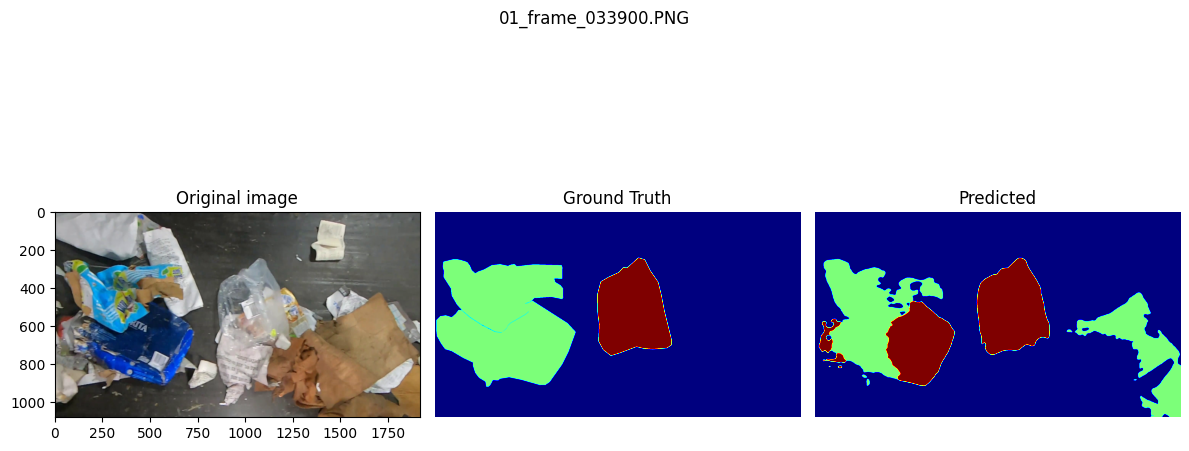

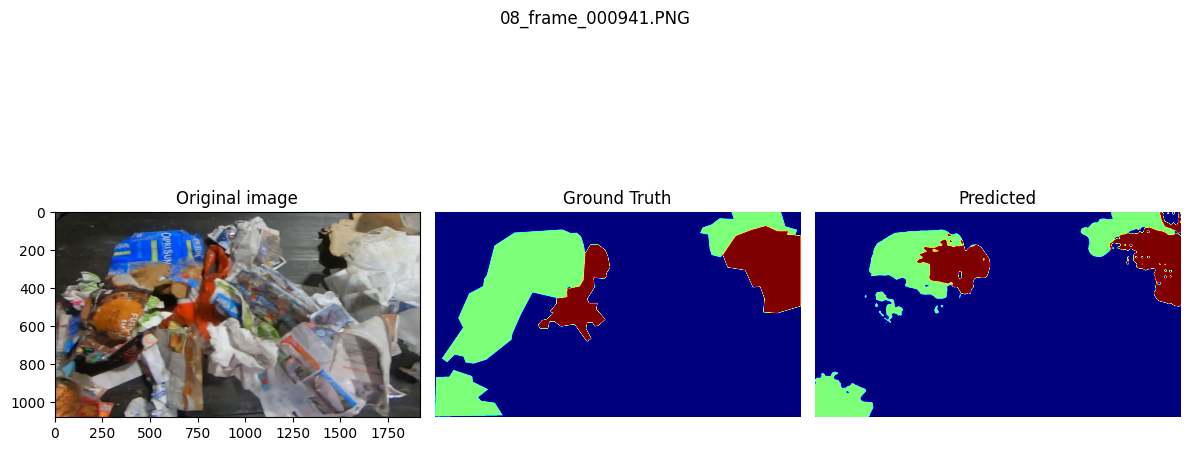

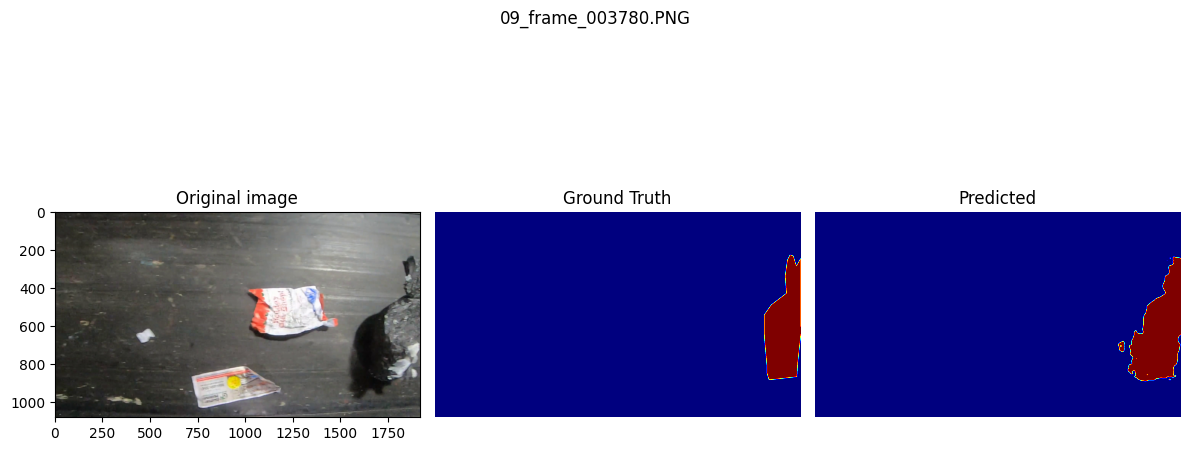

In [22]:
import random

# Выбираем случайно n=3 файлов
sample_files = random.sample(all_gt_fnames, 3)

for fname in sample_files:
    basename = os.path.basename(fname)
    gt_mask_path = os.path.join(GT_MASK_DIR, basename)
    
    gt_mask = io.imread(gt_mask_path)
    pred_mask = pred_mask_dict[fname]

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    original_image = io.imread(os.path.join(IMAGE_DIR, fname))
    axes[0].imshow(original_image)
    axes[0].set_title("Original image")

    axes[1].imshow(gt_mask, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
    axes[2].set_title("Predicted")
    axes[2].axis('off')
    
    fig.suptitle(basename)
    plt.tight_layout()
    plt.show()